In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm, trange
import urllib.request
from PIL import Image
from io import BytesIO

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchvision.io import read_image
from torch import nn, optim
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


import asyncio
from time import perf_counter
import aiohttp
import nest_asyncio
import warnings
warnings.filterwarnings('ignore')


# Run the async function
nest_asyncio.apply()
# Set seed
generator = torch.Generator().manual_seed(2023)
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [102]:
def create_image_dataset():
    """
    Creates an image dataset by fetching thumbnail images from URLs, saving them to a local folder,
    and generating corresponding labels. The dataset is then saved as CSV files.
    """
    
    # Create image folder
    img_folder = '/data/data_thumbnail'
    if not os.path.exists(img_folder):
        os.makedirs(img_folder)

    # Read data from CSV
    data_img = pd.read_csv('data/dien-thoai-may-tinh-bang.csv')

    async def fetch(s, url):
        # Asynchronously fetch image data from the given URL
        async with s.get(f'{url}') as r:
            if r.status != 200:
                r.raise_for_status()
            return await r.read()

    async def fetch_all(s, urls):
        # Fetch image data for all URLs in parallel using asyncio
        tasks = []
        for url in urls:
            task = asyncio.create_task(fetch(s, url))
            tasks.append(task)
        res = await asyncio.gather(*tasks)
        return res

    async def main():
        global urls, htmls

        urls = data_img['thumbnail_url'].tolist()
        async with aiohttp.ClientSession() as session:
            htmls = await fetch_all(session, urls)

    asyncio.run(main())

    # Save fetched image data to files
    path = []
    for html, url in zip(htmls, urls):
        img_name = url.split('/')[-1]
        img_path = f'{img_folder}/{img_name}'
        path.append(img_path)

        with open(img_path, "wb") as f:
            f.write(html)

    # Update data_img DataFrame with image paths and labels
    data_img['img_path'] = pd.Series(path)
    data_img['label'] = data_img['brand_name'] + '_' + data_img['productset_id'].astype(str)


    thumbnail_img = data_img[['label', 'img_path']]
    count_thumbnail = thumbnail_img['label'].value_counts()

    # Drop labels with value_counts < 6
    others = count_thumbnail[count_thumbnail < 6].index
    thumbnail_img['label'] = thumbnail_img['label'].apply(lambda x: 'Others' if x in others else x)
    other_index = thumbnail_img[thumbnail_img.label == 'Others'].index
    thumbnail_img.drop(other_index, inplace=True)

    # Save data csv
    thumbnail_img.to_csv('data/img_data.csv', index=False)
    data_img.to_csv('data/full_data_dien_thoai_may_tinh_bang.csv', index=False)

    print('Save data csv successfully ')


create_image_dataset()


Save data csv successfully 


In [5]:
class Dataset(Dataset):

    # Constructor
    def __init__(self, csv_file, data_dir, transform=None, target_transform=None):

        # Image directory
        self.data_dir=data_dir

        # The transform
        self.transform = transform
        self.target_transform = target_transform

        data_dircsv_file=os.path.join(self.data_dir,csv_file)
        # Load the CSV file contians image info
        self.data_name= pd.read_csv(data_dircsv_file)

        # Number of images in dataset
        self.len=self.data_name.shape[0]

        if self.target_transform:
            labels = self.data_name.iloc[:, 0]
            self.data_name.iloc[:, 0] = LabelEncoder().fit_transform(self.data_name.iloc[:,0])
            encoded_labels = self.data_name.iloc[:, 0]

            # Create a dictionary mapping the labels to their encoded values
            self.dict_label = {encoded_label: label for label, encoded_label in zip(labels, encoded_labels)}

    # Get the length
    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):

        # Image file path
        img_name=os.path.join(self.data_dir,self.data_name.iloc[idx, 1])
        image = Image.open(img_name).convert('RGB')

        # The class label for the image
        y = torch.tensor(self.data_name.iloc[idx, 0]).type(torch.LongTensor)

        # If there is any transform method, apply it
        if self.transform:
            image = self.transform(image)

        return image, y


In [6]:
def setup_transfer_learning_pipeline():
    """
    Sets up the transfer learning pipeline for image classification using a pre-trained ResNet34 model.

    Returns:
    - model: Initialized ResNet34 model with pre-trained weights.
    - criterion: Loss function for training the model.
    - optimizer: Optimizer for updating model parameters during training.
    - train_data: Training dataset.
    - val_data: Validation dataset.
    - test_data: Test dataset.
    - dict_label: Dictionary mapping encoded labels to their original values.
    """
    
    OUTDIMS = 23  #len(thumbnail_img['label'].unique())

    # Initialize model with the best available weights
    weights = models.ResNet34_Weights.DEFAULT
    model = models.resnet34(weights=weights).to(device)

    # Initialize the inference transforms
    preprocess = weights.transforms()

    # Load and preprocess the dataset
    my_data = Dataset('img_data.csv', './data/', transform=preprocess, target_transform=True)
    dict_label = my_data.dict_label

    # Split the dataset into train, validation, and test sets
    train_data, val_data, test_data = random_split(dataset=my_data, lengths=[0.8, 0.1, 0.1], generator=generator)

    # Create a data loader for the training set
    trainloader = DataLoader(dataset=my_data, batch_size=32, generator=generator, shuffle=True)

    # Freeze the parameters of the model, except the final layer
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(512, 23).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=[param for param in model.parameters() if param.requires_grad], lr=0.001)

    return model, criterion, optimizer, train_data, val_data, test_data, dict_label


In [7]:
def train_model(model, criterion, optimizer, train, val, batch_size, epochs):
    """
    Trains the specified model using the given criterion, optimizer, training data, validation data,
    batch size, and number of epochs.

    Returns:
    - history: Dictionary containing the training history (train loss, train accuracy, validation accuracy).
    - best: Dictionary containing the best model and its accuracy.
    """
    
    trainloader = DataLoader(dataset=train, batch_size=batch_size, generator=generator, shuffle=True)
    valloader = DataLoader(dataset=val, batch_size=batch_size, generator=generator, shuffle=True)
    batches_per_epoch = len(trainloader)

    # Initialize variables to track the best model and its accuracy, as well as the training history
    best = {'best_model': None, 'best_acc': 0}
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        with trange(batches_per_epoch, unit='batch') as pbar:
            pbar.set_description(f'{epoch + 1} epoch(s)')

            train_loss = 0
            train_acc = 0
            model.train()
            for x, y in trainloader:
                optimizer.zero_grad()
                x, y = x.to(device), y.to(device)
                yhat = model(x)
                _, label = torch.max(yhat, dim=-1)
                loss = criterion(yhat, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_acc += (label == y).sum().item()
                pbar.update()

            train_acc = round(train_acc / len(train), 3)
            history['train_loss'].append(loss)
            history['train_acc'].append(train_acc)

            # Evaluation mode
            val_acc = 0
            model.eval()
            for x, y in valloader:
                x, y = x.to(device), y.to(device)
                _, label = torch.max(model(x), dim=-1)
                val_acc += (label == y).sum().item()

            val_acc = round(val_acc / len(val), 3)
            history['val_acc'].append(val_acc)

            # Check if the current validation accuracy is the best so far
            if val_acc > best['best_acc']:
                best['best_model'] = deepcopy(model)
                best['best_acc'] = deepcopy(val_acc)

            pbar.set_postfix_str(f'train_loss: {train_loss} train_acc: {train_acc} val_acc: {val_acc}')

    return history, best


In [21]:
model, criterion, optimizer, train_data, val_data, test_data, dict_label = setup_transfer_learning_pipeline()


# Training process
history, best = train_model(model, criterion, optimizer, train_data, val_data, batch_size=128, epochs=25)

25 epoch(s): 100%|██████████| 7/7 [00:06<00:00,  1.02batch/s, train_loss: 2.972934663295746 train_acc: 0.939 val_acc: 0.832]


In [28]:
def save_model(folder):

    best_model = best['best_model']
    model_scripted = torch.jit.script(best_model)  # Export to TorchScript

    # Create the folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    # Save the model in the specified folder
    model_path = os.path.join(folder, 'model_ResNet34_25epochs.pt')
    model_scripted.save(model_path)
    print(f'Save model successfully at {model_path}')

save_model(folder='models')

Save model successfully at models/model_ResNet34_25epochs.pt


CLASSIFICATION REPORT 

                 precision    recall  f1-score   support

    Forme_2649       1.00      0.75      0.86         4
   Kindle_2653       1.00      1.00      1.00         5
     Kobo_2653       1.00      1.00      1.00         1
  Masstel_2649       0.75      1.00      0.86         6
    Nokia_2647       1.00      1.00      1.00         2
    Nokia_2649       1.00      1.00      1.00         2
      OEM_2647       1.00      1.00      1.00         1
      OEM_2649       1.00      0.75      0.86         4
      OEM_2651       1.00      1.00      1.00         3
     OPPO_2647       1.00      1.00      1.00         9
  Oukitel_2647       1.00      1.00      1.00         4
Panasonic_2651       1.00      1.00      1.00         7
  Samsung_2645       1.00      1.00      1.00         1
  Samsung_2647       0.94      1.00      0.97        31
    Tecno_2647       1.00      1.00      1.00         1
     Vivo_2647       1.00      0.80      0.89         5
   Xiaomi_2647       1

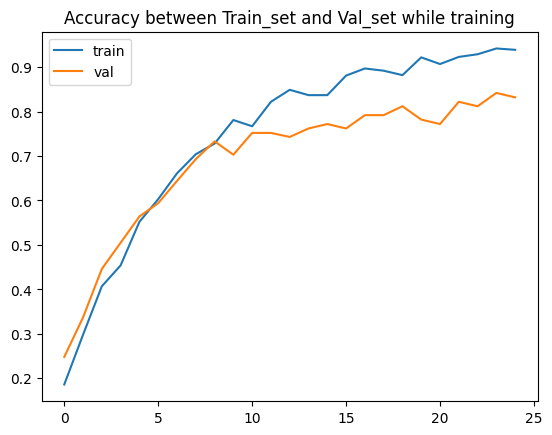

In [69]:
def evaluate_model(test_data, history,dict_label, path_model='models/model_ResNet34_25epochs.pt'):

    # Load model
    model = torch.jit.load(path_model)
    model.eval()

    testloader = DataLoader(dataset=test_data, batch_size=len(test_data))
    acc = 0
    for x, y in testloader:
        x, y = x.to(device), y.to(device)

        yhat = model(x)
        _, label = torch.max(yhat, dim=-1)


    unique_labels = list(set(y.cpu().numpy()))
    y_dict_label = {label: dict_label[label] for label in unique_labels}

    report = classification_report(y.cpu().numpy(), label.cpu().numpy(), target_names=list(y_dict_label.values()))
    print('CLASSIFICATION REPORT \n\n', report)
    print()
    print('-'*80)
    print('\n')
    plt.plot(history['train_acc'], label='train')
    plt.plot(history['val_acc'], label='val')
    plt.title('Accuracy between Train_set and Val_set while training')
    plt.legend()
    plt.show()

evaluate_model(test_data, history, dict_label)